### Global imports

In [2]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

### Encapsulated local imports

In [29]:
from const import Settings
from data import (
    extract_dataset_globs,
    get_labels,
    get_train_transforms,
    get_test_transforms,
    CatsDogsDataset
)

In [15]:
# Additional convenience

!jupyter nbextension enable --py widgetsnbextension

%load_ext autoreload
%autoreload 2

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Process the Cats&Dogs dataset into the runtime

In [5]:
train_list, test_list = extract_dataset_globs(half=True)

print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 12500
Test Data: 6250


In [6]:
labels = get_labels(train_list)

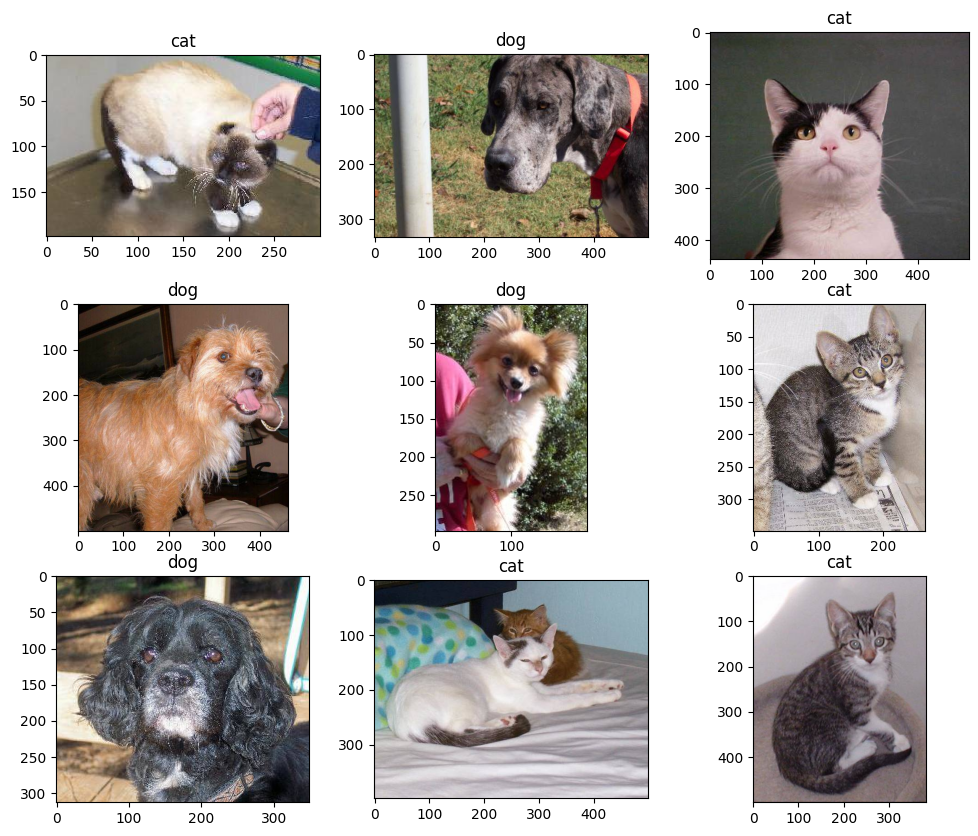

In [7]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

## Preprocessing

In [8]:
train_list, valid_list = train_test_split(
    train_list, test_size=0.2, stratify=labels, random_state=Settings.seed
)

In [9]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 10000
Validation Data: 2500
Test Data: 6250


In [10]:
train_transforms = get_train_transforms()
test_transforms = get_test_transforms()
# TODO: не будет ли бага из-за неявного копирования?
val_transforms = get_test_transforms()

In [11]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [12]:
train_loader = DataLoader(dataset=train_data, batch_size=Settings.batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=Settings.batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=Settings.batch_size, shuffle=True)

## Modelling

### Visual transformer initialization

In [ ]:
# TODO: change to inefficient
from ground_truth_vit import ViT


model = ViT(
    dim=128,
    mlp_dim=128,
    depth=12,
    heads=8,
    image_size=224,
    patch_size=32,
    num_classes=2,
    channels=3,
).to(Settings.device)

### Checking inefficient VIT

In [52]:
from vit import ViT as WeakViT

model = WeakViT(
    dim=16,
    mlp_dim=16,
    depth=2,
    heads=1,
    dim_head=32,
    image_size=224,
    patch_size=32,
    num_classes=2,
    channels=3,
).to(Settings.device)

## Training with PyTorch Profiler

In [53]:
import typing as tp

# TODO: remove record_function from this place when it comes to task description

def train() -> tp.Tuple[float, float]:
    epoch_loss, epoch_accuracy = 0, 0
    for i, (data, label) in tqdm(enumerate(train_loader)):
        data = data.to(Settings.device)
        label = label.to(Settings.device)
        with record_function("model_forward"):
            output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        with record_function("model_backward"):
            loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    return epoch_loss, epoch_accuracy


def evaluate():
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(Settings.device)
            label = label.to(Settings.device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    return epoch_val_loss, epoch_val_accuracy

In [54]:
from torch.profiler import profile, record_function, ProfilerActivity


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=Settings.lr)
scheduler = StepLR(optimizer, step_size=1, gamma=Settings.gamma)

for epoch in range(Settings.epochs):
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
        epoch_loss, epoch_accuracy = train()
    epoch_val_loss, epoch_val_accuracy = evaluate()
    print(
        f"Epoch: {epoch+1} - loss: {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss: {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

STAGE:2023-01-28 16:50:34 59645:59645 ActivityProfilerController.cpp:294] Completed Stage: Warm Up


0it [00:00, ?it/s]

STAGE:2023-01-28 16:50:34 59645:59645 ActivityProfilerController.cpp:300] Completed Stage: Collection


RuntimeError: running_mean should contain 50 elements not 16

In [ ]:
import pandas as pd

inputs = torch.randn(16, 3, 224, 224)
names = []
total_cpu = []
total_cuda = []
profiling_keys = [
    "model_forward", "model_backward", "mlp_head",
    "attention", "feedforward", "positional", "embedding",
]


for key in prof.key_averages():
    if key.key in profiling_keys:
        names.append(key.key)
        total_cpu.append(f"{key.cpu_time / 1000}ms")
        total_cuda.append(f"{key.cuda_time / 1000}ms")


result = pd.DataFrame({"CPU": total_cpu, "CUDA": total_cuda}, index=names)
result

In [ ]:
result.to_csv("metrics_1.csv", index=False)